In [ ]:
import random
import copy
import numpy as np
from itertools import combinations
from enum import Enum

# 牌局定义

In [6]:
class Action(Enum):
    FOLD = 0
    CALL = 1
    RAISE = 2

class Stage(Enum):
    PREFLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3
    SHOWDOWN = 4

class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"
    
def create_deck():
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck

def card_value(c):
    order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'T':10,'J':11,'Q':12,'K':13,'A':14}
    return order[c.rank]

def check_straight(vals):
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None

def evaluate_5card_hand(cards):
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight:
        return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush:
        return (5, tuple(vals))
    if straight:
        return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))

def evaluate_hand(hole, community):
    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best:
            best = rank
    return best


In [17]:
class PokerGame:
    def __init__(self, agents):
        self.agents = agents
        self.stacks = [100 for _ in agents]  # 每个玩家初始100筹码
        self.deck = []
        self.hole_cards = [[] for _ in agents]
        self.community = []

    def reset(self):
        self.deck = create_deck()
        self.community = []
        self.hole_cards = [[self.deck.pop(), self.deck.pop()] for _ in self.agents]

    def deal_community(self, num):
        for _ in range(num):
            self.community.append(self.deck.pop())

    def showdown(self):
        hands = [evaluate_hand(hole, self.community) for hole in self.hole_cards]
        winner = max(enumerate(hands), key=lambda x: x[1])[0]
        return winner

    def play_round(self):
        self.reset()

        pot = 0
        fold_status = [False for _ in self.agents]

        # PREFLOP
        for i, agent in enumerate(self.agents):
            action = agent.act(self.hole_cards[i], self.community)
            if action == Action.FOLD:
                fold_status[i] = True
            else:
                pot += 1
                self.stacks[i] -= 1

        # FLOP
        self.deal_community(3)
        for i, agent in enumerate(self.agents):
            if not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    pot += 1
                    self.stacks[i] -= 1

        # TURN
        self.deal_community(1)
        for i, agent in enumerate(self.agents):
            if not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    pot += 1
                    self.stacks[i] -= 1

        # RIVER
        self.deal_community(1)
        for i, agent in enumerate(self.agents):
            if not fold_status[i]:
                action = agent.act(self.hole_cards[i], self.community)
                if action == Action.FOLD:
                    fold_status[i] = True
                else:
                    pot += 1
                    self.stacks[i] -= 1

        # Showdown
        active_players = [i for i, f in enumerate(fold_status) if not f]
        if len(active_players) == 1:
            winner = active_players[0]
        else:
            winner = self.showdown()

        self.stacks[winner] += pot
        return winner

# Random Agent

In [13]:
# random agent 
class RandomAgent:
    def act(self, hole_cards, community_cards):
        return random.choice(list(Action))

# Equity Agent

In [14]:
# equity agent
class EquityAgent:
    def act(self, hole_cards, community_cards):
        if len(community_cards) < 5:
            return Action.CALL
        # 如果胜率高，激进
        equity = self.estimate_equity(hole_cards, community_cards)
        if equity > 0.6:
            return Action.RAISE
        elif equity > 0.4:
            return Action.CALL
        else:
            return Action.FOLD
        
    def estimate_equity(self, hole_cards, community_cards, n_simulations=20):
        wins = 0
        for _ in range(n_simulations):
            deck = create_deck()
            known = hole_cards + community_cards
            deck = [card for card in deck if card not in known]
            opp_hole = [deck.pop(), deck.pop()]
            remaining = community_cards + [deck.pop() for _ in range(5-len(community_cards))]
            my_hand = evaluate_hand(hole_cards, remaining)
            opp_hand = evaluate_hand(opp_hole, remaining)
            if my_hand > opp_hand:
                wins += 1
        return wins / n_simulations


# CFR Agent

In [26]:
import torch

class CFRAgent:
    def __init__(self):
        self.regret_sum = {a: 0.0 for a in Action}
        self.strategy_sum = {a: 0.0 for a in Action}

    def get_strategy(self):
        normalizing_sum = sum([max(r,0) for r in self.regret_sum.values()])
        if normalizing_sum > 0:
            strategy = {a: max(self.regret_sum[a],0)/normalizing_sum for a in Action}
        else:
            strategy = {a: 1/len(Action) for a in Action}
        return strategy

    def act(self, hole_cards, community_cards):
        strategy = self.get_strategy()
        actions = list(strategy.keys())
        probs = list(strategy.values())
        action = random.choices(actions, probs)[0]
        return action

    def train(self, hole_cards, community_cards):
        strategy = self.get_strategy()
        util = {a: 0.0 for a in Action}

        # 简单模拟对手动作
        opp_action = random.choice(list(Action))
        opp_utility = 1 if opp_action == Action.FOLD else -1

        for a in Action:
            if a == Action.RAISE:
                util[a] = 1
            elif a == Action.CALL:
                util[a] = 0
            else:  # FOLD
                util[a] = -1

        node_utility = sum([strategy[a] * util[a] for a in Action])
        for a in Action:
            regret = util[a] - node_utility
            self.regret_sum[a] += regret

    def get_state(self):
        """保存模型用"""
        return {
            'regret_sum': {a.name: v for a, v in self.regret_sum.items()},
            'strategy_sum': {a.name: v for a, v in self.strategy_sum.items()},
        }

    def load_state(self, state_dict):
        """加载模型用"""
        self.regret_sum = {Action[a]: v for a, v in state_dict['regret_sum'].items()}
        self.strategy_sum = {Action[a]: v for a, v in state_dict['strategy_sum'].items()}

    def save(self, filename):
        """保存到.pt文件"""
        torch.save(self.get_state(), filename)

    def load(self, filename):
        """从.pt文件加载"""
        state = torch.load(filename)
        self.load_state(state)

# 模拟训练

In [ ]:
cfr_agent.save('cfr_agent.pt')

Saved model at game 0
Saved model at game 100
Saved model at game 200
Saved model at game 300
Saved model at game 400
Saved model at game 500
Saved model at game 600
Saved model at game 700
Saved model at game 800
Saved model at game 900
Saved final cfr agent model


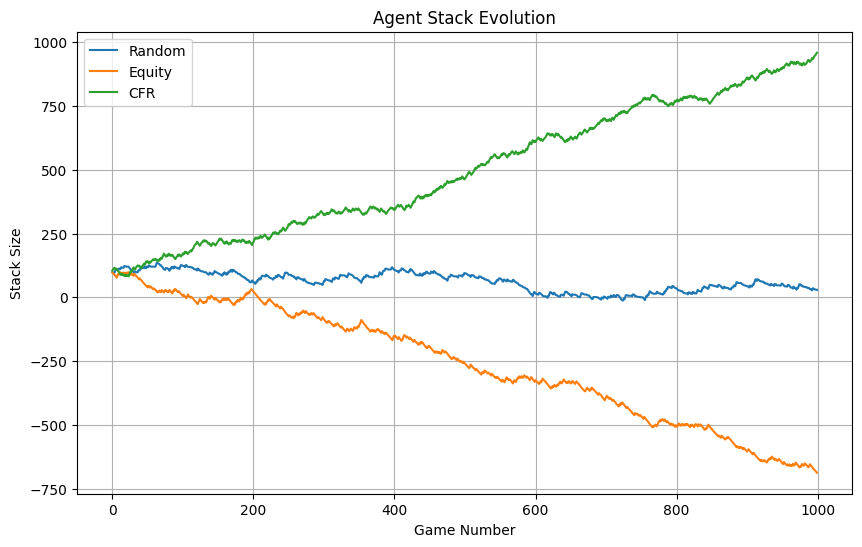

In [29]:
random_agent = RandomAgent()
equity_agent = EquityAgent()
cfr_agent = CFRAgent()

agents = [random_agent, equity_agent, cfr_agent]
agent_names = ['Random', 'Equity', 'CFR']

game = PokerGame(agents)

num_games = 1000
cfr_train_iters = 10

records = [[] for _ in agents]

for i in range(num_games):
    for _ in range(cfr_train_iters):
        cfr_agent.train([], [])

    winner = game.play_round()

    for idx, stack in enumerate(game.stacks):
        records[idx].append(stack)

    # 每100局保存一次
    if i % 100 == 0:
        cfr_agent.save(f'cfr_agent_checkpoint_{i}.pt')
        print(f"Saved model at game {i}")

cfr_agent.save('cfr_agent_final.pt')
print(f"Saved final cfr agent model")

# 绘图
plt.figure(figsize=(10,6))
for idx, rec in enumerate(records):
    plt.plot(rec, label=agent_names[idx])
plt.xlabel("Game Number")
plt.ylabel("Stack Size")
plt.title("Agent Stack Evolution")
plt.legend()
plt.grid()
plt.show()

In [1]:





# ###########################################################################################

# import random
# import copy
# import numpy as np
# from itertools import combinations
# from enum import Enum
# import matplotlib.pyplot as plt
# from collections import defaultdict

# # --- 你的 MultiAgentHoldem 和辅助函数都放在这里（略） ---

# # --- 1. Random Agent ---
# class RandomAgent:
#     def select_action(self, obs):
#         legal_moves = obs['legal_moves']
#         return random.choice(legal_moves) if legal_moves else Action.FOLD.value

# # --- 2. Simplified Tabular CFR Agent ---
# class CFR_Agent:
#     def __init__(self):
#         self.regret_sum = defaultdict(lambda: np.zeros(3))  # 3 actions: FOLD, CALL, RAISE
#         self.strategy_sum = defaultdict(lambda: np.zeros(3))

#     def _get_strategy(self, infoset):
#         regrets = self.regret_sum[infoset]
#         positive_regrets = np.maximum(regrets, 0)
#         normalizing_sum = positive_regrets.sum()
#         if normalizing_sum > 0:
#             return positive_regrets / normalizing_sum
#         else:
#             return np.array([1/3, 1/3, 1/3])  # Uniform random if no positive regret

#     def select_action(self, obs):
#         infoset = self._extract_infoset(obs)
#         strategy = self._get_strategy(infoset)
#         legal = obs['legal_moves']
#         probs = np.array([strategy[a] if a in legal else 0 for a in range(3)])
#         probs /= probs.sum()
#         return np.random.choice(range(3), p=probs)

#     def train(self, env, iterations=1):
#         for _ in range(iterations):
#             self._cfr(env)

#     def _cfr(self, env):
#         env_copy = copy.deepcopy(env)
#         self._cfr_recursive(env_copy, player_id=0)

#     def _cfr_recursive(self, env, player_id):
#         if env.stage == Stage.SHOWDOWN or env._only_one_left():
#             return self._get_payoff(env, player_id)

#         current_player = env.current_player
#         obs = env._get_observation(current_player)
#         infoset = self._extract_infoset(obs)
#         legal_moves = obs['legal_moves']

#         strategy = self._get_strategy(infoset)

#         util = np.zeros(3)
#         node_utility = 0

#         for a in legal_moves:
#             env_copy = copy.deepcopy(env)
#             obs_next, reward, done, info = env_copy.step(current_player, a)
#             util[a] = -self._cfr_recursive(env_copy, player_id)
#             node_utility += strategy[a] * util[a]

#         for a in legal_moves:
#             regret = util[a] - node_utility
#             self.regret_sum[infoset][a] += regret
#             self.strategy_sum[infoset][a] += strategy[a]

#         return node_utility

#     def _get_payoff(self, env, player_id):
#         alive = [i for i in range(env.num_players) if not env.folded[i]]
#         scores = [(i, evaluate_hand(env.hands[i], env.community_cards)) for i in alive]
#         scores.sort(key=lambda x: x[1], reverse=True)
#         winner = scores[0][0]
#         return 1 if winner == player_id else -1

#     def _extract_infoset(self, obs):
#         # 只用 hole cards 和 stage 简化成 infoset
#         return tuple(obs['hole'] + obs['stage'])

# # --- 3. 训练和测试主循环 ---
# if __name__ == "__main__":
#     random_agents = [RandomAgent(), RandomAgent()]
#     cfr_agent = CFR_Agent()
#     agents = [cfr_agent] + random_agents  # player 0 是 CFR agent

#     num_players = 3
#     env = MultiAgentHoldem(num_players=num_players)

#     total_rounds = 100
#     cfr_training_iterations_per_game = 10

#     win_counts = np.zeros(num_players)
#     win_record = []

#     for episode in range(total_rounds):
#         obs = env.reset()
#         done = False
#         while not done:
#             player = env.current_player
#             obs = env._get_observation(player)
#             action = agents[player].select_action(obs)
#             obs, reward, done, info = env.step(player, action)
#             if done and 'winner' in info:
#                 win_counts[info['winner']] += 1

#         # After each round, train CFR agent
#         cfr_agent.train(env, iterations=cfr_training_iterations_per_game)
#         win_record.append(win_counts.copy())

#         if (episode+1) % 10 == 0:
#             print(f"Episode {episode+1}: Win counts = {win_counts}")

#     # Plotting the win rates
#     win_record = np.array(win_record)
#     plt.figure(figsize=(10,6))
#     for pid in range(num_players):
#         plt.plot((win_record[:, pid] / (np.arange(1, total_rounds+1))), label=f"Player {pid} {'(CFR)' if pid == 0 else '(Random)'}")
#     plt.xlabel("Game")
#     plt.ylabel("Win Rate")
#     plt.title("Win Rate Evolution Over Games")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# # if __name__ == '__main__':
# #     env = MultiAgentHoldem(num_players=3)
# #     obs = env.reset()
# #     done = False
# #     while not done:
# #         player = env.current_player
# #         legal = obs['legal_moves']
# #         action = random.choice(legal) if legal else Action.FOLD.value
# #         obs, reward, done, info = env.step(player, action)
# #         print(f"Player {player} Action: {Action(action).name} | Reward: {reward} | Info: {info}")

    


ModuleNotFoundError: No module named 'matplotlib'